### Connection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from graphdatascience import GraphDataScience

URI = "neo4j://localhost:7687"
NAME_DB = "movies"

gds = GraphDataScience(URI, aura_ds=False, database=NAME_DB)

# Graph Analytics
In this section there will be two types of graph analysis:
- Similarity to create a recommendations systems
- Community detection

These two analysis will be done in a correlation way: results on similarity analysis will be use to do a better community detection.

## Similarity Analysis
Similarity analysis is done by considering the entire graph with all information added in preprocessing and exploratory analysis sections.  
![db_schema_after_exploratory.png](images/db_schema_after_exploratory.png)

As we can also see in the output of the second cell, the density of the graph is slightly increased with the added relations.  

Similarity analysis will be done in two way:
- Based on nodes relations
- Based on nodes properties  

So will be calculate similarity on Users and Movies nodes.  

In [2]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'movies-analyzed',
    {
        Movie:{properties:['popularity','favoriteMonth','year']},
        User:{properties: ['binaryGender','age','occupation', 'activity','favoriteMonth']},
        Genre:{}
    },
    {
        RATED: {properties: 'rating', orientation: 'UNDIRECTED'},
        BELONGS:{},
        LIKES:{properties: 'score', orientation: 'UNDIRECTED'}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,movies-analyzed,"{'User': {'label': 'User', 'properties': {'occ...",9764,"{'RATED': {'aggregation': 'DEFAULT', 'orientat...",2067010


In [3]:
gds.run_cypher(
    """
    CALL gds.graph.list('movies-analyzed')
    YIELD density,degreeDistribution;
"""
)

,density,degreeDistribution
0,0.021684,"{'min': 2, 'max': 3430, 'p90': 520, 'p999': 25..."


### Similarity based on relationships
In this similarity analysis will be used node the [Node Similarity](https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/) algorithm in the Neo4j Graph Data Science library based on Jaccard similarity metrics.  
There're not similarities cut off to capture also dissimilarity relations between nodes.

#### Users likes genres
This similarity analysis adds SIMILAR weighted relations between users with similar connections User-Genre.

In [4]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['User','Genre'],
        relationshipTypes:['LIKES'],
        relationshipWeightProperty: 'score', 
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'score'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 60580

{'min': 0.06453561782836914, 'p5': 0.6140856742858887, 'max': 1.000007152557373, 'p99': 0.9694628715515137, 'p1': 0.5606303215026855, 'p10': 0.6280817985534668, 'p90': 0.9293932914733887, 'p50': 0.6569972038269043, 'p25': 0.6435465812683105, 'p75': 0.8449816703796387, 'p95': 0.948005199432373, 'mean': 0.7196209100812684, 'p100': 1.000007152557373, 'stdDev': 0.12534100269606865}


#### Movies belongs genres
This similarity analysis adds SIMILAR weighted relations between movies with similar connections Movie-Genre.  
This analysis is most of time much higher because we don't have much diversification on the datasets.

In [5]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['Movie','Genre'],
        relationshipTypes:['BELONGS'], 
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'score'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 37060

{'min': 0.3333320617675781, 'p5': 0.6666660308837891, 'max': 1.0000057220458984, 'p99': 1.0000057220458984, 'p1': 0.5000019073486328, 'p10': 0.7500019073486328, 'p90': 1.0000057220458984, 'p50': 1.0000057220458984, 'p25': 1.0000057220458984, 'p75': 1.0000057220458984, 'p95': 1.0000057220458984, 'mean': 0.9644405418000733, 'p100': 1.0000057220458984, 'stdDev': 0.10531082468910871}


#### Users rate movies
This other similarity analysis adds SIMILAR_RATE weighted relations between users with similar connections User-Movie.  

This analysis is more precise and captures user behaviour within the network and finds more correct correlations.  
However, the similarities with values ​​greater than 50% are very few (around 500).  
it was decided to keep the relationships with low similarity so that they can be considered as weak links in the community detection phase

In [6]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['User','Movie'],
        relationshipTypes:['RATED'], 
        writeRelationshipType: 'SIMILAR_RATE',
        writeProperty: 'score',
        relationshipWeightProperty: 'rating'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 97460

{'min': 0.0006622485816478729, 'p5': 0.08452987298369408, 'max': 1.000007625669241, 'p99': 0.41802405938506126, 'p1': 0.04854368790984154, 'p10': 0.10306453332304955, 'p90': 0.2982768975198269, 'p50': 0.19173431023955345, 'p25': 0.1443777047097683, 'p75': 0.24431895837187767, 'p95': 0.33333396539092064, 'mean': 0.19930887553231588, 'p100': 1.000007625669241, 'stdDev': 0.08485594652098076}


#### Movies rated by users
This other similarity analysis adds SIMILAR_RATE weighted relations between movies with similar connections Movie-User.  

This analysis could be more precise and captures the popularity and appreciation of the movies within the network and finds more correct correlations. However, also here the similarities with values ​​greater than 50% are very few (around 500).  
It was decided to keep the relationships with low similarity so that they can be considered as weak links in the community detection phase.

In [7]:
result = gds.run_cypher(
    """
    CALL gds.nodeSimilarity.write('movies-analyzed',
    {
        nodeLabels:['Movie','User'],
        relationshipTypes:['RATED'], 
        relationshipWeightProperty: 'rating',
        writeRelationshipType: 'SIMILAR_RATE',
        writeProperty: 'score'
    }) 
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 97460

{'min': 0.0006622485816478729, 'p5': 0.08452987298369408, 'max': 1.000007625669241, 'p99': 0.41802405938506126, 'p1': 0.04854368790984154, 'p10': 0.10306453332304955, 'p90': 0.2982768975198269, 'p50': 0.19173431023955345, 'p25': 0.1443777047097683, 'p75': 0.24431895837187767, 'p95': 0.33333396539092064, 'mean': 0.19930887553231588, 'p100': 1.000007625669241, 'stdDev': 0.08485594652098076}


### Similarity based on components
In this other similarity analysis will be used node the [K-Nearest Neighbors](https://neo4j.com/docs/graph-data-science/current/algorithms/knn/) algorithm in the Neo4j Graph Data Science library based on Jaccard similarity metrics.  

N.B.: concurrency:1 and randomSeed: 42 configurations are need to have same results on these tests

#### Users
This similarity analysis adds SIMILAR_KNN weighted relations between users with similar properties.  

In [8]:
result = gds.run_cypher(
    """
    CALL gds.knn.write('movies-analyzed', {
        nodeLabels:['User'], 
        writeRelationshipType: 'SIMILAR_KNN',
        writeProperty: 'score',
        topK: 100, 
        concurrency: 1, 
        randomSeed: 42,
        nodeProperties: ['binaryGender','age','occupation', 'activity','favoriteMonth']})
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 604000

{'min': 0.5333328247070312, 'p5': 0.6733322143554688, 'max': 1.0000038146972656, 'p99': 1.0000038146972656, 'p1': 0.6374969482421875, 'p10': 0.6999969482421875, 'p90': 0.8666648864746094, 'p50': 0.7666664123535156, 'p25': 0.7285690307617188, 'p75': 0.8285713195800781, 'p95': 0.8999977111816406, 'mean': 0.7798828902844561, 'p100': 1.0000038146972656, 'stdDev': 0.07183889894803831}


#### Movies
This similarity analysis adds SIMILAR_KNN weighted relations between movies with similar properties.  

In [9]:
result = gds.run_cypher(
    """
    CALL gds.knn.write('movies-analyzed', {
        nodeLabels:['Movie'],
        writeRelationshipType: 'SIMILAR_KNN',writeProperty: 'score',
        topK: 100,
        concurrency: 1,
        randomSeed: 42,
        nodeProperties: ['popularity','favoriteMonth','year']})
    """
)
print(f"Similarity relations created: {result.loc[0]['relationshipsWritten']}\n")
print(result.loc[0]["similarityDistribution"])

Similarity relations created: 370600

{'min': 0.38400840759277344, 'p5': 0.6111125946044922, 'max': 1.0000057220458984, 'p99': 1.0000057220458984, 'p1': 0.5085468292236328, 'p10': 0.6734676361083984, 'p90': 0.8333339691162109, 'p50': 0.7777767181396484, 'p25': 0.7037029266357422, 'p75': 0.8333339691162109, 'p95': 1.0000057220458984, 'mean': 0.7738579039205684, 'p100': 1.0000057220458984, 'stdDev': 0.10234434117405922}


## Recommendation Systems
After similarity analysis the graph become like this:  
![alt text](images/movies_with_similarity.svg)  
Having these information we can build a recommendation system mixed with relations similarity and components similarity.
  
Init our pseudo-random generator with fixed seed.

In [10]:
import random

random.seed(0)

### Movie based
We choose a random film from dataset

In [11]:
movieId = random.randint(0, 3952)

gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId = {movieId}
    RETURN m.movieId as movieId,m.title as title
    """
).loc[0]["title"]

'Blood and Sand (Sangre y Arena) (1989)'

After that we pick 60 movies similar based our three similarity metrics (20 movies for each).  

We joins these three lists and calculate a mixed score metrics with different weights  
__general_score = scoreGenre * .2 + scoreRate * .5 + scoreKnn * .3__  

Sorts list by `general_score` and filter first 10


In [12]:
# I take the top 20 most similar films according to previously created similarity edges for each similarity type
list_with_similar_genre = gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR]-(m2:Movie)
    RETURN DISTINCT m2.movieId as movieId, s.score as scoreGenre
    ORDER BY scoreGenre DESC
    limit 20
    """
)
list_with_similar_rate = gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR_RATE]-(m2:Movie)
    RETURN DISTINCT m2.movieId as movieId, s.score as scoreRate
    ORDER BY scoreRate DESC
    limit 20
    """
)
list_with_similar_knn = gds.run_cypher(
    f"""
    MATCH (m:Movie WHERE m.movieId = {movieId})-[s:SIMILAR_KNN]-(m2:Movie)
    RETURN DISTINCT m2.movieId as movieId, s.score as scoreKnn
    ORDER BY scoreKnn DESC
    limit 20
    """
)

# I merge the lists
list = pd.merge(
    list_with_similar_genre, list_with_similar_rate, how="outer", on="movieId"
)
list = list.merge(list_with_similar_knn, how="outer", on="movieId")

# I fill in the missing values with 0
list.fillna(0, inplace=True)

# I calculate the general score
list["general_score"] = (
    list["scoreGenre"] * 0.2 + list["scoreRate"] * 0.5 + list["scoreKnn"] * 0.3
)

# I sort the list by general score and take the top 10
list.sort_values(by="general_score", ascending=False, inplace=True)
list.reset_index(drop=True, inplace=True)

# I pick the top 10 movies
list = list.head(10)

list

,movieId,scoreGenre,scoreRate,scoreKnn,general_score
0,3166,0.0,0.0,1.000000,0.300000
1,3123,0.0,0.0,1.000000,0.300000
2,2039,0.0,0.0,1.000000,0.300000
3,706,0.0,0.6,0.000000,0.300000
4,3687,0.0,0.0,0.833333,0.250000
5,1989,0.0,0.0,0.833333,0.250000
6,142,0.0,0.0,0.833333,0.250000
7,1107,0.0,0.0,0.777778,0.233333
8,868,0.0,0.0,0.777778,0.233333
9,2742,0.0,0.0,0.750000,0.225000


With a simple query we can have our 10 recommended movies

In [13]:
gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId IN {list['movieId'].tolist()}
    RETURN m.movieId as movieId,m.title as title
    """
)

,movieId,title
0,142,Shadows (Cienie) (1988)
1,706,Sunset Park (1996)
2,868,Death in Brunswick (1991)
3,1107,Loser (1991)
4,1989,Prom Night III: The Last Kiss (1989)
5,2039,Cheetah (1989)
6,2742,M�nage (Tenue de soir�e) (1986)
7,3123,Spring Fever USA (a.k.a. Lauderdale) (1989)
8,3166,Brenda Starr (1989)
9,3687,Light Years (1988)


### User based
We choose a random user

In [14]:
userId = random.randint(1, 6040)

gds.run_cypher(
    f"""
    MATCH (u:User {{userId: {userId}}})
    RETURN u.gender as gender, u.age as age, u.occupation as occupation, u.activity as activity, u.favoriteMonth as favoriteMonth
    """
)

,gender,age,occupation,activity,favoriteMonth
0,M,1,10,4,8


After that we pick the top 30 user similar based our three similarity metrics (10 user for each).  

We joins these three lists and calculate a mixed score metrics with different weights  
__general_score = scoreGenre * .2 + scoreRate * .5 + scoreKnn * .3__  

Sorts list by `general_score` and filter first 10

In [15]:
# I take the top 10 most similar users according to previously created similarity edges for each similarity type
list_with_similar_genre = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.userId = {userId})-[s:SIMILAR]-(u2:User)
    RETURN DISTINCT u2.userId as userId, s.score as scoreGenre
    ORDER BY scoreGenre DESC
    limit 10
    """
)
list_with_similar_rate = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.userId = {userId})-[s:SIMILAR_RATE]-(u2:User)
    RETURN DISTINCT u2.userId as userId, s.score as scoreRate
    ORDER BY scoreRate DESC
    limit 10
    """
)
list_with_similar_knn = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.userId = {userId})-[s:SIMILAR_KNN]-(u2:User)
    RETURN DISTINCT u2.userId as userId, s.score as scoreKnn
    ORDER BY scoreKnn DESC
    limit 10
    """
)

# I merge the lists
list = pd.merge(
    list_with_similar_genre, list_with_similar_rate, how="outer", on="userId"
)
list = list.merge(list_with_similar_knn, how="outer", on="userId")

# I fill in the missing values with 0
list.fillna(0, inplace=True)

# I calculate the general score
list["general_score"] = (
    list["scoreGenre"] * 0.2 + list["scoreRate"] * 0.5 + list["scoreKnn"] * 0.3
)

# I sort the list by general score
list.sort_values(by="general_score", ascending=False, inplace=True)
list.reset_index(drop=True, inplace=True)

# I pick the top 10 users
list = list.head(10)

list

,userId,scoreGenre,scoreRate,scoreKnn,general_score
0,3710,0.0,0.0,1.000000,0.30
1,3537,0.0,0.0,1.000000,0.30
2,3843,0.0,0.0,0.900000,0.27
3,3667,0.0,0.0,0.900000,0.27
4,3865,0.0,0.0,0.900000,0.27
5,4997,0.0,0.0,0.900000,0.27
6,3382,0.0,0.0,0.900000,0.27
7,4102,0.0,0.0,0.900000,0.27
8,3904,0.0,0.0,0.866667,0.26
9,3573,0.0,0.0,0.866667,0.26


Having the 10 most similar people, for each one I select the 3 most liked films that have not yet been seen by the person taken as an example. 

I group the results and if I find films recommended by several people I add up their general_score.

Finally I select the top 10

In [16]:
# I take the top 3 favorite movies of the top 10 similar users
movies_list = pd.DataFrame()
for _, similar_user in list.iterrows():
    favorite_movies = gds.run_cypher(
        f"""
        MATCH (uSample:User{{userId: {userId}}})
        MATCH (u:User {{userId: {similar_user['userId']}}})-[r:RATED]->(m:Movie)
        WHERE NOT (uSample)-[:RATED]->(m)
        RETURN m.movieId as movieId, r.rating as rating
        ORDER BY rating DESC
        LIMIT 3
        """
    )
    favorite_movies["general_score"] = similar_user["general_score"]
    movies_list = pd.concat([movies_list, favorite_movies])

# I group the results and if I find the movies recommended by more people I sum their general_score.
movies_list = movies_list.groupby(by="movieId").agg(
    {"general_score": "sum", "rating": "size"}
)
movies_list.columns = ["general_score", "times"]

# I sort the list by general score and take the top 10
movies_list.sort_values(by="general_score", ascending=False, inplace=True)
movies_list = movies_list.head(10)

movies_list

,general_score,times
movieId,,
3752,0.30,1
3744,0.30,1
3646,0.30,1
2795,0.30,1
2027,0.30,1
1223,0.30,1
364,0.27,1
3556,0.27,1
3408,0.27,1


With a simple query we can have our 10 recommended movies

In [17]:
gds.run_cypher(
    f"""
    MATCH (m:Movie) WHERE m.movieId IN {movies_list.index.to_list()}
    RETURN m.movieId as movieId,m.title as title
    """
)

,movieId,title
0,364,Lion King The (1994)
1,1223,Grand Day Out A (1992)
2,2027,Mafia! (1998)
3,2795,Vacation (1983)
4,2966,Straight Story The (1999)
5,3408,Erin Brockovich (2000)
6,3556,Virgin Suicides The (1999)
7,3646,Big Momma's House (2000)
8,3744,Shaft (2000)
9,3752,Me Myself and Irene (2000)


## Community detection
Thanks to similarity analysis we have a subgraph on which we can do community detection.  
This is the structure of `users-similarities`  
![alt text](images/users_similarities.svg)  

This one is a little part of the graph with 300 Users nodes  
![alt text](images/users_similarities_300_nodes.svg)
 

In [18]:
result = gds.run_cypher(
    """
    CALL gds.graph.project(
    'users-similarities',
    'User',
    {
        SIMILAR_KNN: {properties: 'score', orientation: 'UNDIRECTED'},
        SIMILAR: {properties: 'score', orientation: 'UNDIRECTED'},
        SIMILAR_RATE: {properties: 'score', orientation: 'UNDIRECTED'}
    }
    )
    YIELD
    graphName AS graph, nodeProjection, nodeCount AS nodes, relationshipProjection, relationshipCount AS rels
"""
)
result

,graph,nodeProjection,nodes,relationshipProjection,rels
0,users-similarities,"{'User': {'label': 'User', 'properties': {}}}",6040,"{'SIMILAR_RATE': {'aggregation': 'DEFAULT', 'o...",1570400


The density of this subgraph is much higher than all graph. This is done to do a better community detection.

In [19]:
gds.run_cypher(
    """
    CALL gds.graph.list('users-similarities')
    YIELD density,degreeDistribution;
"""
)

,density,degreeDistribution
0,0.043053,"{'min': 133, 'max': 565, 'p90': 322, 'p999': 4..."


### Check some stats from Neo4j algorithms

#### Strongly Connected Components
The network is an entire strongly connected component

In [20]:
gds.run_cypher(
    """
    CALL gds.scc.stats('users-similarities')
    YIELD componentCount, componentDistribution
    """
)

,componentCount,componentDistribution
0,1,"{'min': 6040, 'p5': 6040, 'max': 6040, 'p999':..."


#### Louvain stats
The [louvain](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/) stats find 7-8 community with a good modularity (0.3<Q<0.7).  

In [21]:
gds.run_cypher(
    """
    CALL gds.louvain.stats('users-similarities', 
    { 
        relationshipWeightProperty: 'score'
    })
    YIELD communityCount, modularity, modularities
"""
)

,communityCount,modularity,modularities
0,8,0.603401,"[0.4868902057967937, 0.5955241459721875, 0.603..."


### Define communities
This cell will define community id for each nodes. In this way it can be possible to analyze differences between communities.

In [22]:
gds.run_cypher(
    """
    CALL gds.louvain.write('users-similarities', 
    { 
        writeProperty:'communityId',
        relationshipWeightProperty: 'score'
    })
    YIELD communityCount, modularity, modularities
"""
)

,communityCount,modularity,modularities
0,9,0.595806,"[0.4869507747179441, 0.5879382134876128, 0.595..."


We print all communities with its size and we pick the first two.

In [23]:
result = gds.run_cypher(
    """
    MATCH (u:User)
    RETURN u.communityId as communityId, COUNT(*) as numNodes
    ORDER BY numNodes DESC
    
    """
)
communities = result["communityId"].to_dict()
result

,communityId,numNodes
0,4890,1193
1,2083,1103
2,4403,874
3,4184,643
4,2104,579
5,1642,550
6,4942,496
7,1978,380
8,2656,222


### Community1 vs Community2

#### Users
We wil see which users are insides of the two communities.

##### Prepare data for comparison

In [24]:
from helpers import AGE_LABELS, OCCUPATION_LABELS

users = gds.run_cypher(
    f"""
    MATCH (u:User)
    RETURN u.age AS age, u.occupation AS occupation, u.gender AS gender, u.favoriteMonth AS favoriteMonth, u.activity AS activity, u.communityId AS communityId
    """
)

# Prepare labels for each property
genders_label = (
    pd.Series(index=users.gender.value_counts().index.to_list()).fillna(0).astype(int)
)
ages_label = pd.Series(index=AGE_LABELS.values()).fillna(0).astype(int)
occupations_label = pd.Series(index=OCCUPATION_LABELS.values()).fillna(0).astype(int)
activities_label = pd.Series(index=range(1, 11)).fillna(0).astype(int)
favoriteMonths_label = pd.Series(index=range(1, 13)).fillna(0).astype(int)

# Create data frames for each property of the two communities to compare them in a bar chart
genders = pd.DataFrame(
    {
        "Gen X (35-44)": genders_label.combine(
            users["gender"][users["communityId"] == communities[1]].value_counts(), max
        ),
        "Gen Y (25-34)": genders_label.combine(
            users["gender"][users["communityId"] == communities[0]].value_counts(), max
        ),
        "Gen Z (18-24)": genders_label.combine(
            users["gender"][users["communityId"] == communities[2]].value_counts(), max
        ),
    },
    index=genders_label.index,
)

ages = pd.DataFrame(
    {
        "Gen X (35-44)": ages_label.combine(
            users["age"][users["communityId"] == communities[1]]
            .value_counts()
            .rename(index=AGE_LABELS),
            max,
        ),
        "Gen Y (25-34)": ages_label.combine(
            users["age"][users["communityId"] == communities[0]]
            .value_counts()
            .rename(index=AGE_LABELS),
            max,
        ),
        "Gen Z (18-24)": ages_label.combine(
            users["age"][users["communityId"] == communities[2]]
            .value_counts()
            .rename(index=AGE_LABELS),
            max,
        ),
    },
    index=ages_label.index,
)

occupations = pd.DataFrame(
    {
        "Gen X (35-44)": occupations_label.combine(
            users["occupation"][users["communityId"] == communities[1]]
            .value_counts()
            .rename(index=OCCUPATION_LABELS),
            max,
        ),
        "Gen Y (25-34)": occupations_label.combine(
            users["occupation"][users["communityId"] == communities[0]]
            .value_counts()
            .rename(index=OCCUPATION_LABELS),
            max,
        ),
        "Gen Z (18-24)": occupations_label.combine(
            users["occupation"][users["communityId"] == communities[2]]
            .value_counts()
            .rename(index=OCCUPATION_LABELS),
            max,
        ),
    },
    index=occupations_label.index,
)

activities = pd.DataFrame(
    {
        "Gen X (35-44)": activities_label.combine(
            users["activity"][users["communityId"] == communities[1]].value_counts(),
            max,
        ),
        "Gen Y (25-34)": activities_label.combine(
            users["activity"][users["communityId"] == communities[0]].value_counts(),
            max,
        ),
        "Gen Z (18-24)": activities_label.combine(
            users["activity"][users["communityId"] == communities[2]].value_counts(),
            max,
        ),
    },
    index=activities_label.index,
)

favoriteMonths = pd.DataFrame(
    {
        "Gen X (35-44)": favoriteMonths_label.combine(
            users["favoriteMonth"][
                users["communityId"] == communities[1]
            ].value_counts(),
            max,
        ),
        "Gen Y (25-34)": favoriteMonths_label.combine(
            users["favoriteMonth"][
                users["communityId"] == communities[0]
            ].value_counts(),
            max,
        ),
        "Gen Z (18-24)": favoriteMonths_label.combine(
            users["favoriteMonth"][
                users["communityId"] == communities[2]
            ].value_counts(),
            max,
        ),
    },
    index=favoriteMonths_label.index,
)

##### Comparison
By viewing the graphs, we can already define the three communities according to age as there is a clear division on this attribute:
- Gen X (35-44) --> 2° Community
- Gen Y (25-34) --> 1° Community
- Gen Z (18-24) --> 3° Community
  
About gender:  
In all three groups males then females like the entire datasets.  
Little differences: there are more males in Gen X and Gen Z then Gen Y where is more balanced but not too much.  

About occupations:
- Gen X has a balance distribution to all occupations.
- Gen Y hasa less balanced distribution with fewer categories (many students, managers and non-specific occupation).
- Gen Y has a balance distribution but with a large peak on students who are the net majority.  

About activity comparison:  
All have fairly balanced distributions.  
Gen Y has the most active people while Gen X has the least active people.  

About favorite comparison:  
Also here, all have fairly balanced distributions.  
All three generations have similar behaviour to the complete dataset

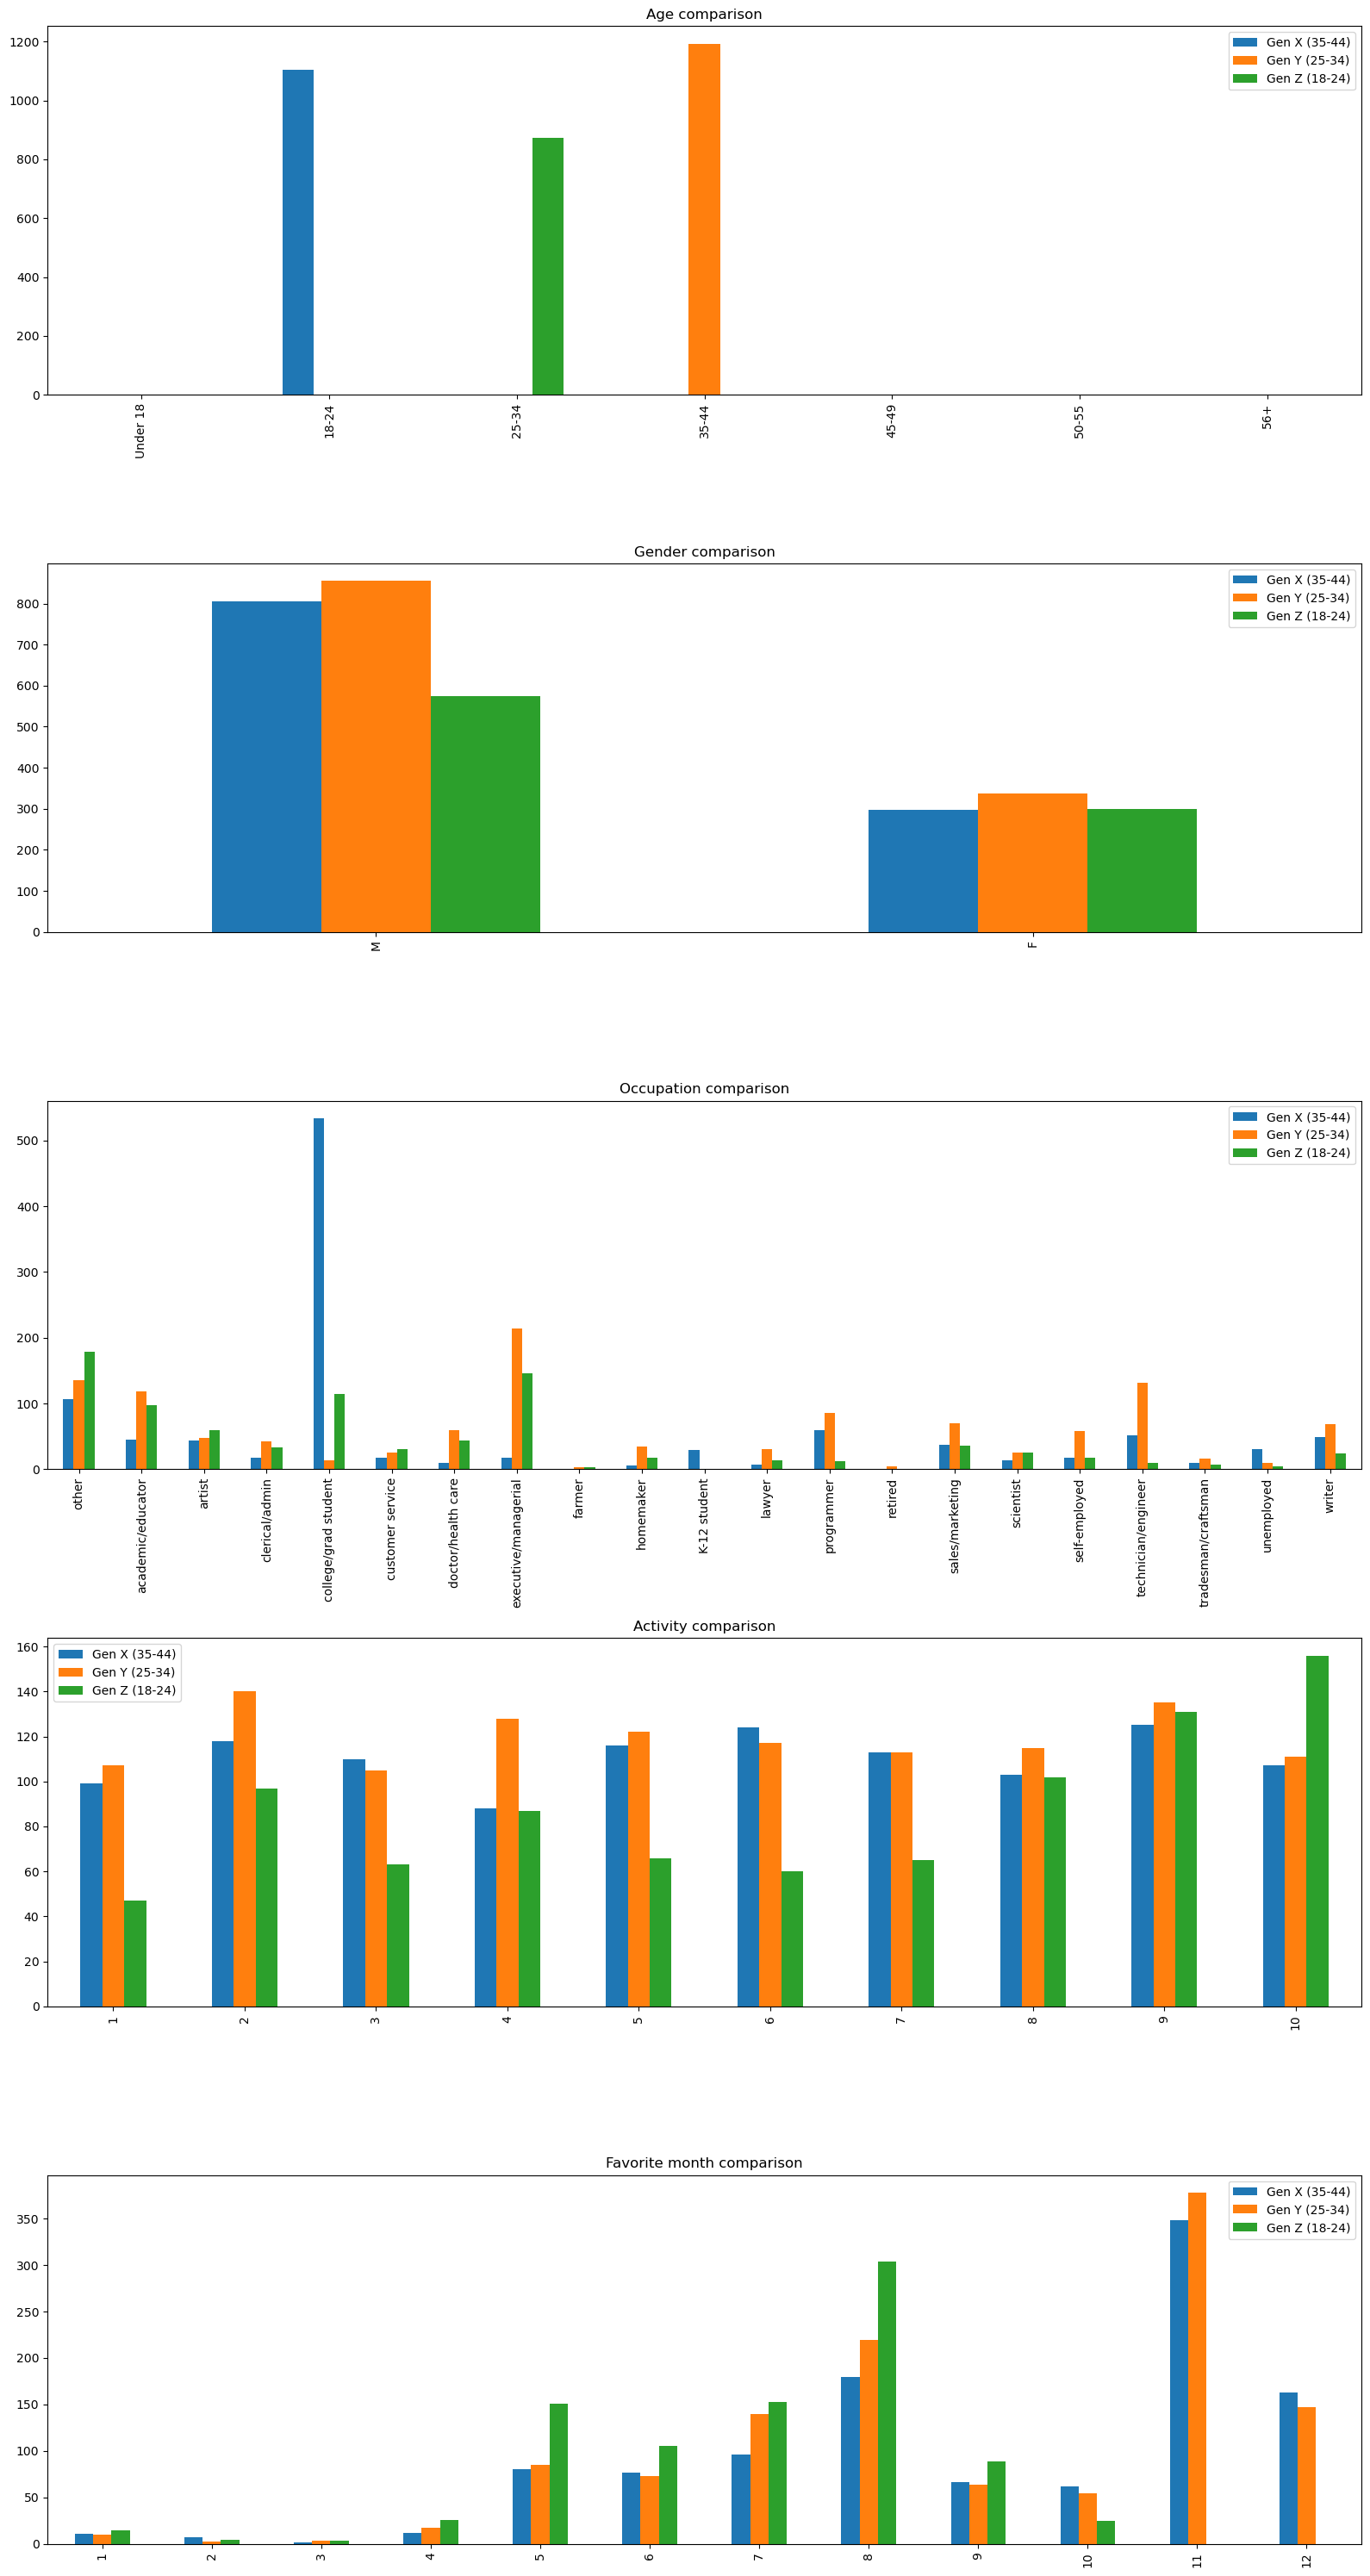

In [25]:
fig, axs = plt.subplots(5, 1, figsize=(16, 30))

ages.plot(kind="bar", ax=axs[0], title="Age comparison")
genders.plot(kind="bar", ax=axs[1], title="Gender comparison")
occupations.plot(kind="bar", ax=axs[2], title="Occupation comparison")
activities.plot(kind="bar", ax=axs[3], title="Activity comparison")
favoriteMonths.plot(kind="bar", ax=axs[4], title="Favorite month comparison")

plt.tight_layout()

#### Movies

##### Prepare data for comparison

In [26]:
movies_1 = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communities[0]})-[r:RATED]->(m:Movie)
    RETURN m.title AS title, m.year AS year, m.popularity AS popularity
    """
)
movies_2 = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communities[1]})-[r:RATED]->(m:Movie)
    RETURN m.title AS title, m.year AS year, m.popularity AS popularity
    """
)
movies_3 = gds.run_cypher(
    f"""
    MATCH (u:User WHERE u.communityId={communities[2]})-[r:RATED]->(m:Movie)
    RETURN m.title AS title, m.year AS year, m.popularity AS popularity
    """
)

##### Comparison
As one could imagine, the different generations are connected to the films of their years.  
Gen X watched old and new films, gen Y watched some old films and gen Z watched more new films.

With regard to the popularity of films, all three generations watch the most popular films in the same way.  
Generation Y has a higher presence of very popular films watched

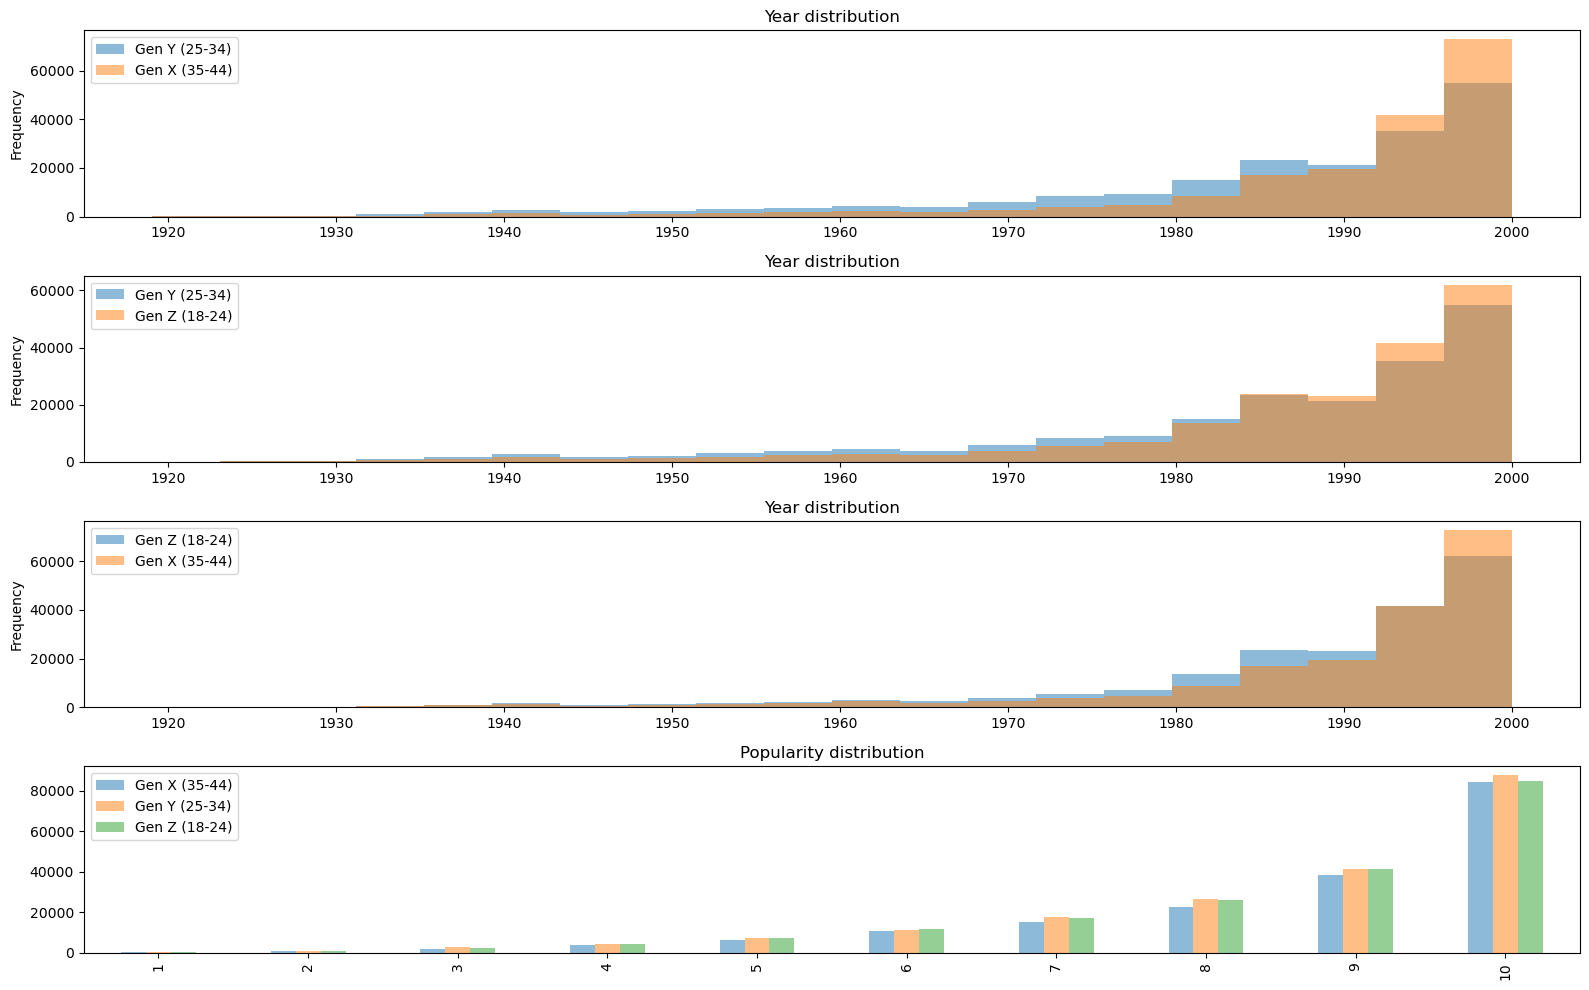

In [27]:
fig, axs = plt.subplots(4, 1, figsize=(16, 10))

popularity_label = pd.Series(index=range(1, 11)).fillna(0).astype(int)

pd.DataFrame(
    {
        "Gen Y (25-34)": movies_1["year"].sort_values(),
        "Gen X (35-44)": movies_2["year"].sort_values(),
    }
).plot(kind="hist", bins=20, alpha=0.5, title="Year distribution", ax=axs[0])

pd.DataFrame(
    {
        "Gen Y (25-34)": movies_1["year"].sort_values(),
        "Gen Z (18-24)": movies_3["year"].sort_values(),
    }
).plot(kind="hist", bins=20, alpha=0.5, title="Year distribution", ax=axs[1])

pd.DataFrame(
    {
        "Gen Z (18-24)": movies_3["year"].sort_values(),
        "Gen X (35-44)": movies_2["year"].sort_values(),
    }
).plot(kind="hist", bins=20, alpha=0.5, title="Year distribution", ax=axs[2])

pd.DataFrame(
    {
        "Gen X (35-44)": popularity_label.combine(
            movies_2["popularity"].value_counts(), max
        ),
        "Gen Y (25-34)": popularity_label.combine(
            movies_1["popularity"].value_counts(), max
        ),
        "Gen Z (18-24)": popularity_label.combine(
            movies_3["popularity"].value_counts(), max
        ),
    },
    index=range(1, 11),
).plot(kind="bar", alpha=0.5, title="Popularity distribution", ax=axs[3])

plt.tight_layout()

# Conclusions
In this study, we have seen ways of gaining information through graph analytics.   
In fact, starting from a simple bipartite graph, we were able to add nodes and relations in order to derive more information than simple relations based on ratings.  

In the similarity section we saw this advantage, as the similarity based on ratings had a very low distribution and few links with high similarity to be able to create a good recommendation system.  
Calculate different similarities based on different aspects such as relationships between films, genres and similar properties between nodes. This can add noise that can be corrected by creating a criterion to put the different similarities together into a single similarity factor.  
In this study, the overall score was calculated in preprocessing but there is nothing to prevent it from being calculated on the entire graph to replace all similarity relations with a single one. This was not done to allow more accurate community detection. 

In community detection, it was noted that similarity links helped to find communities with good modularity.  
Comparison between the three largest communities shows that the different distributions are similar to those of the entire dataset. The behavior of users analyzed on this data seems consistent with the beliefs: the younger generations are mostly students and watch films of their generation, while the older generations are related to the same generation.  
It has been noticed that generation Y has a significant influence on the trends of the entire dataset and is the community with the most active people.  

Finally, the study did not achieve sensational results and findings, but it was a good example in which a dataset with little information was enriched with properties and relationships thanks to graph analytics.
The aim of this project was to explore the use of neo4j and what can be obtained from a dataset with many connections but little information for each node and knowing how to derive it from their behavior in the network.